[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab7_style_transfer.ipynb)

# Style Transfer

In this lab, you will implement the style transfer algorithm proposed by [Gatys et. al. (2016)](https://arxiv.org/pdf/1508.06576.pdf). Your goal is to produce an image that has the high-level content of one image and the low-level style of another.

To perform style transfer, we will use a neural network as a feature extractor to determine style and content features, and we will optimize an image to reach a balance of the chosen style and content. Note that the network does not generate the final image, nor is the network trained at any point in this lab; instead of training network weights, we train the image itself. Through this lab, you will experience another way to use neural networks and see how deep learning can be used to optimize structures other than neural networks.


## Grading standards
Your code will be graded on the following:

* 20% Correct extraction of image statistics
* 35% Correct construction of loss function in a loss class
* 20% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 15% Correct initialization and optimization of image variable
* 10% Awesome looking final image

---

Here's an additional example of style transfer:

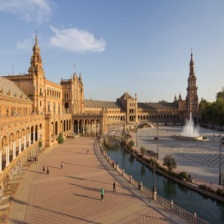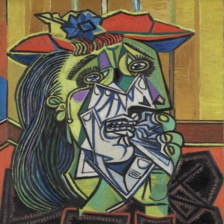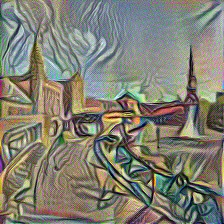

---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from torch.nn.parameter import Parameter
from PIL import Image
import io

# IF NOT USING COLAB: comment out the following import statement:
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Select two images: one for content and one for style. The images should have noticeably different content and style from each other to make it clear if the style transfer worked.

In [22]:
# Use this code to upload your own images.
# NOTE: if you are not using Colab, `upload()` will not work. Just make sure the images are on your file system and set `content_path` and `style_path` accordingly.

load_and_normalize = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving Florence-Skyline-at-sunset-1024x681.jpg to Florence-Skyline-at-sunset-1024x681 (2).jpg

Upload Style Image


Saving stardew2.jpg to stardew2.jpg
Content Path: <_io.BytesIO object at 0x7cb9d82963e0>
Style Path: <_io.BytesIO object at 0x7cb9e478fe70>


In [23]:
# Load in and normalize the images
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(content_image_orig).unsqueeze(0).to(device)
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(style_image_orig).unsqueeze(0).to(device)


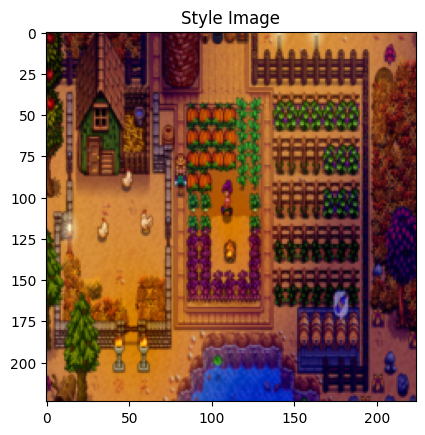

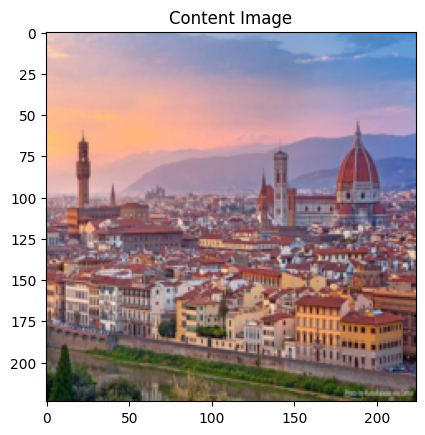

In [24]:
# Display the images
toPIL = transforms.ToPILImage()

def display(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

## Part 1

We will use a pretrained VGG-16 network as a feature extractor to get the style and content statistics from the images.

We provide you with the `VGGIntermediate` class to load in the pretrained model and to grab intermediate layers.



* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image

**DONE:**



In [36]:
import torchvision.models as models

# You should not have to change any of the code in the following classes.

# Normalization layer normalizes the image pixels to mean=0 std=1 according to the statistics of the ImageNet training dataset (which the VGG was pretrained on)
class Normalization(nn.Module):
  def __init__(self):
      super(Normalization, self).__init__()
      self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
      self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)

  def forward(self, img):
      return (img - self.mean) / self.std

# Wrapper for the pretrained VGG-16. Instead of returning the output of the VGG, it returns the `requested` layers.
class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place.
          m.inplace = False          # the model has a hard time going backwards on the in place functions.

        if i in requested:
          # This stores the output of the requested layer as `intermediates[i]`
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))

  def forward(self, x):
    self.vgg(self.norm(x))
    return self.intermediates.copy()

We provide you with the list of VGG-16 layer names. Select the names of the layers you'd like to use to extract the content and style ([Gatys et. al. (2016)](https://arxiv.org/pdf/1508.06576.pdf) has suggestions on which layers to use on pages 3 and 12).

Save the layer indexes (not names) into a list for the `requested` parameter of `VGGIntermediate`.

In [37]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

In [38]:
# Select the layer indices for content and style extraction
content_layers = [22]  # Example: relu4_2
style_layers = [3, 8, 15, 22, 29] # Example: relu1_2, relu2_2, relu3_3, relu4_3, relu5_3

# Combine content and style layers to pass to VGGIntermediate
all_layers = sorted(list(set(content_layers + style_layers)))

Create a `VGGIntermediate` object, providing it with the intermediate layers. You can use a single network to extract both the content and the style, but be sure to keep track of which layers are which.

In [39]:
# Initialize the VGGIntermediate object
vgg_model = VGGIntermediate(requested=all_layers).to(device)

Use your `VGGIntermediate` network to extract the content from `content_image` and the style from `style_image`. Save these tensors: they will be used throughout training! Be sure to detach these tensors, since these are our labels and we don't want to backpropagate with respect to them.

In [40]:
# Extract content and style features
content_features = vgg_model(content_image)
style_features = vgg_model(style_image)

# Detach the tensors
content_targets = {layer: content_features[layer].detach() for layer in content_layers}
style_targets = {layer: style_features[layer].detach() for layer in style_layers}

---

## Part 2

The loss functions are key to learning the correct behavior in any machine learning problem. For style transfer, we have two losses: content loss and style loss. Our final loss is a combination of both to provide a balance between these competing objectives.

Show that you understand style transfer by describing the key equations of [Gatys et al. 2016](https://arxiv.org/pdf/1508.06576.pdf) in your own words. You may need to read the surrounding sections to understand the equations.

Content Loss:

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English. Include the meaning of all variables and what each dimension represents for each matrix and vector variable.

$\mathcal{L}_{content}(\vec{p}, \vec{x}, l) = \frac{1}{2}\sum_{i,j} (F^l_{ij} - P^l_{ij})^2$

**Your answer here**

The content loss is half of the squared Euclidean distance between the flattened feature maps of the generated image and the content image at a given layer. Minimizing this loss encourages the generated image to have similar feature activations as the content image at that layer, thus preserving the content.

Style Loss:

- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and what each dimension represents for each matrix and vector variable (including the output).

$G^l_{ij} = \sum_k F^l_{ik} F^l_{jk}$

**Your answer here**

The Gram matrix is calculated by taking the outer product of the feature maps at a given layer and summing over the spatial dimensions. This results in a matrix where each element $G^l_{ij}$ represents the correlation between feature map $i$ and feature map $j$ at layer $l$.


- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and what each dimension represents for each matrix and vector variable.

$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j} (G^l_{ij} - A^l_{ij})^2$

**Your answer here**

This equation calculates the difference between the style of the generated image and the style of the original style image at a particular layer by comparing their respective Gram matrices.


- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

$\mathcal{L}_{style}(\vec{a}, \vec{x}) = \sum^L_{l=0} w_lE_l$

**Your answer here**

By summing the weighted style errors from multiple layers, the total style loss captures the overall style difference between the generated image and the style image across different levels of abstraction in the network. Minimizing this total style loss encourages the generated image to adopt the style of the original style image.

___

## Part 3
Now that you understand the loss functions mathematically, create modules that calculate the content and style loss for a single content or style layer.

Since the targets will be static throughout learning (the content and style images don't change, nor the network), we can store them in the loss module objects, so we don't have to pass them into the forward each time.

In [41]:
# Produces a gram matrix from a 4D tensor input
def gram_matrix(F):
    # Reshape the tensor to (batch_size, num_channels, height * width)
    # The batch_size is typically 1 for a single image
    batch_size, num_channels, height, width = F.size()
    F = F.view(batch_size, num_channels, height * width)

    # Compute the gram matrix by multiplying the reshaped tensor with its transpose
    # This results in a matrix of size (batch_size, num_channels, num_channels)
    gram = torch.bmm(F, F.transpose(1, 2))
    return gram

# Represents the content loss function for a single content layer
class ContentLoss(nn.Module):
  # Since the targets don't change, store the targets in the init
  def __init__(self, target):
      super().__init__()
      # Detach the target so gradients are not computed for it
      self.target = target.detach()

  def forward(self, y_hat):
      # Calculate the content loss as the mean squared error between the input and the target
      # We use F.mse_loss which calculates the mean of the squared differences.
      # The paper uses sum, but mean also works and is common in implementations.
      loss = F.mse_loss(y_hat, self.target)
      return loss

# Instantiate a content loss module for each content layer
#  with the content reference image outputs for that layer for comparison
content_losses = [ContentLoss(content_targets[layer]) for layer in content_layers]

# Instantiate a style loss module for each style layer
#  with the style reference image outputs for that layer for comparison
# The StyleLoss class will be implemented next.
style_losses = []

Now that you have a list of loss modules, write a loss function that computes the combined style transfer loss. You can weight the overall content and style losses, as well as weighting each layerwise loss value.

Return the combined loss as a tensor for learning. Return the content and style loss values for plotting.

In [42]:
# Represents the style loss function for a single style layer
class StyleLoss(nn.Module):
    # Since the targets don't change, store the targets in the init
    def __init__(self, target_feature):
        super().__init__()
        # Detach the target so gradients are not computed for it
        self.target = gram_matrix(target_feature).detach()

    def forward(self, y_hat):
        # Calculate the gram matrix for the input
        G = gram_matrix(y_hat)

        # Calculate the style loss as the mean squared error between the input gram matrix and the target gram matrix
        # The paper uses sum and a normalization factor, but mean also works and is common in implementations.
        loss = F.mse_loss(G, self.target)
        return loss

# Instantiate a style loss module for each style layer
#  with the style reference image outputs for that layer for comparison
style_losses = [StyleLoss(style_targets[layer]) for layer in style_layers]


def total_loss(generated_features, content_losses, style_losses, content_weight=1.0, style_weight=100000.0):
    # Calculate the total content loss
    content_l = 0
    for i, cl in enumerate(content_losses):
        content_l += cl(generated_features[content_layers[i]])

    # Calculate the total style loss
    style_l = 0
    for i, sl in enumerate(style_losses):
        style_l += sl(generated_features[style_layers[i]])

    # Combine the content and style losses with their respective weights
    total_l = content_weight * content_l + style_weight * style_l

    return total_l, content_l, style_l

___

## Part 4
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**



First, we need to define our image. While we can create a random image and hope that the optimization works, the best results come from using a clone of the content image. That way, the image starts with the desired content and the content loss only needs to preserve the existing content.

Create a clone of the content image as your initial "generated" image. Calculate and print content and style loss (separately) for your generated image. What do you notice about these losses? Make sure the losses match what you'd expect, given that the generated image is a copy of the content image.

In [43]:
# Create a clone of the content image as the initial generated image
generated_im = content_image.clone().requires_grad_(True)

# Calculate and print initial content and style losses
vgg_model.eval() # Set model to evaluation mode

with torch.no_grad(): # No need to calculate gradients for initial losses
    initial_features = vgg_model(generated_im)
    total_l, initial_content_loss, initial_style_loss = total_loss(initial_features, content_losses, style_losses)

print(f"Initial Content Loss: {initial_content_loss.item():.4f}")
print(f"Initial Style Loss: {initial_style_loss.item():.4f}")

Initial Content Loss: 0.0000
Initial Style Loss: 2490872320.0000


Prepare your generated image for optimization. You need two things:


1.   Your generated image must require gradients: set requires_grad to true by setting the object parameter `requires_grad` or calling the function `requires_grad_()`.
2.   Create an optimizer with your generated image as the parameter. Torch optimizers expect a list of parameters (or tensors), so you'll need to wrap your generated image in a single-item list for the optimizer.



In [44]:
# Prepare your generated image to learn
generated_im.requires_grad_(True)

# Create your optimizer: we suggest starting using an Adam optimizer with lr=.1
optimizer = optim.Adam([generated_im], lr=0.1)

Now create and run your training loop, storing content and style losses as you train. Remember, you will be optimizing the **generated image** according to the content and style statistics extracted with the network. Print your final image.

For best results, use `torch.clamp_(generated_im.data, 0, 1)` to keep your pixel values in range after each learning step.

Style transfer is very susceptible to overtraining, which introduces a lot of noise to the final image. Print your image often during the training process to find the best-looking image.

  9%|▉         | 46/500 [00:01<00:12, 35.92it/s]

Epoch 50/500, Content Loss: 5.1384, Style Loss: 47916724.0000


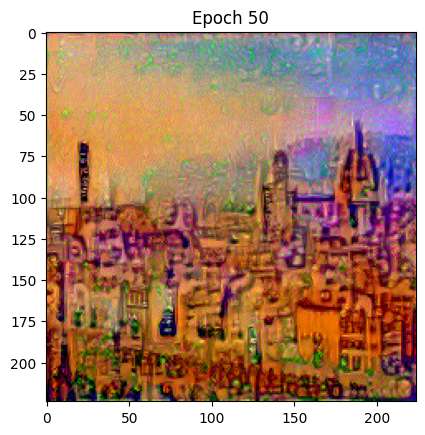

 20%|█▉        | 98/500 [00:02<00:11, 36.22it/s]

Epoch 100/500, Content Loss: 5.4313, Style Loss: 13848960.0000


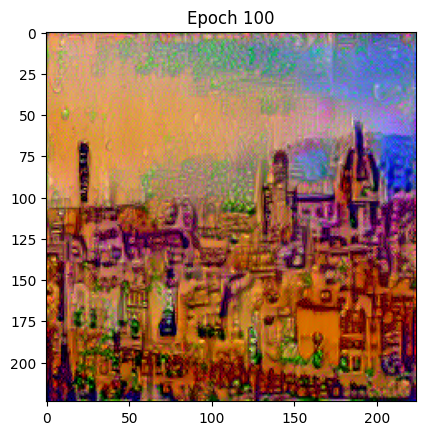

 29%|██▉       | 146/500 [00:04<00:09, 35.87it/s]

Epoch 150/500, Content Loss: 5.5110, Style Loss: 7654692.5000


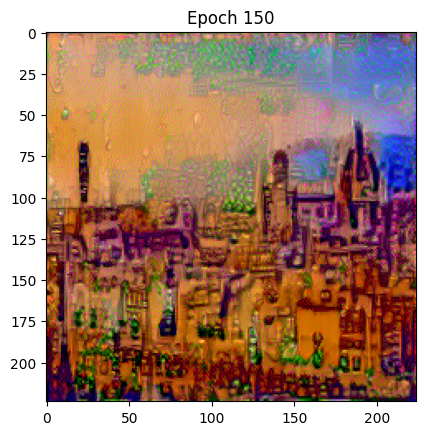

 40%|███▉      | 198/500 [00:06<00:08, 35.66it/s]

Epoch 200/500, Content Loss: 5.5439, Style Loss: 5189644.5000


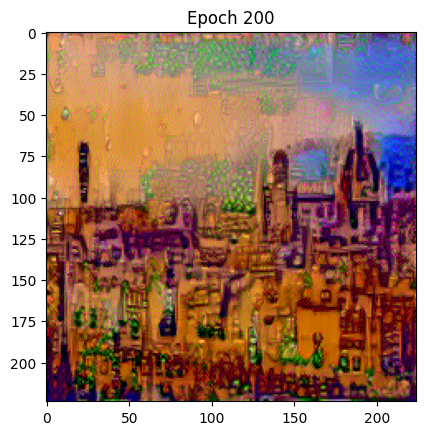

 49%|████▉     | 246/500 [00:07<00:07, 35.37it/s]

Epoch 250/500, Content Loss: 5.5789, Style Loss: 3898372.7500


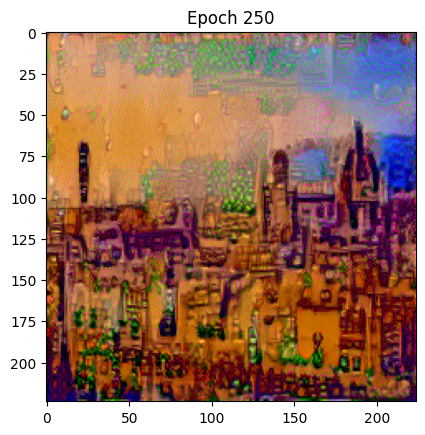

 60%|█████▉    | 298/500 [00:09<00:05, 35.90it/s]

Epoch 300/500, Content Loss: 5.6970, Style Loss: 10775603.0000


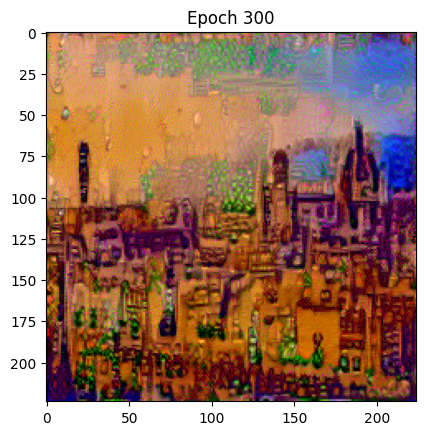

 69%|██████▉   | 346/500 [00:10<00:04, 35.12it/s]

Epoch 350/500, Content Loss: 5.5282, Style Loss: 6707139.5000


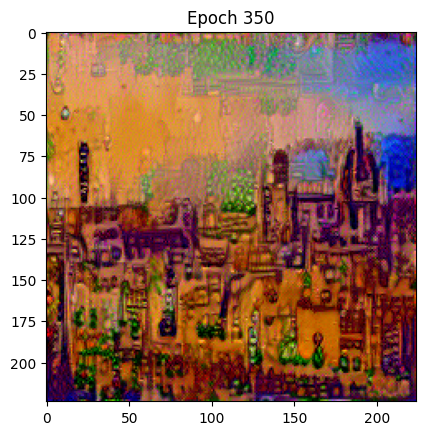

 80%|███████▉  | 398/500 [00:12<00:02, 35.41it/s]

Epoch 400/500, Content Loss: 5.6894, Style Loss: 2435972.2500


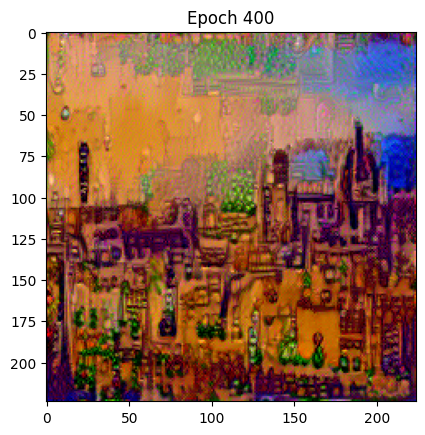

 89%|████████▉ | 446/500 [00:13<00:01, 35.17it/s]

Epoch 450/500, Content Loss: 5.7404, Style Loss: 7398887.5000


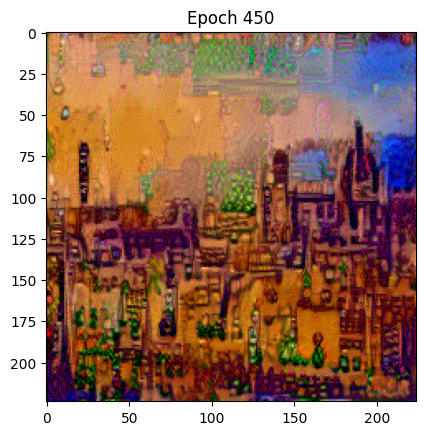

100%|█████████▉| 498/500 [00:15<00:00, 35.21it/s]

Epoch 500/500, Content Loss: 5.7571, Style Loss: 22798092.0000


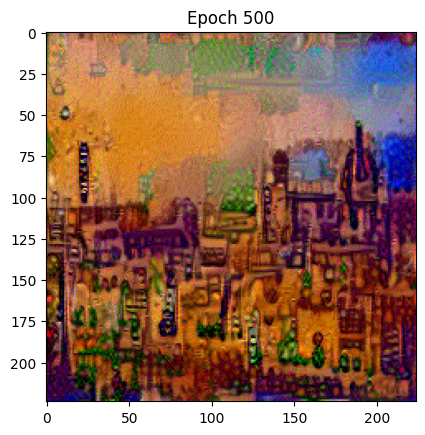

100%|██████████| 500/500 [00:15<00:00, 31.69it/s]


Finished Training.


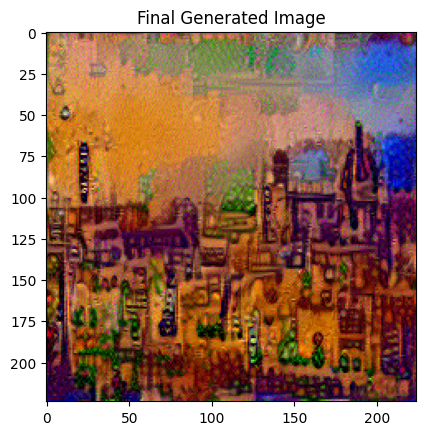

In [45]:
# Run the training loop
epochs = 500 # You can adjust this
print_every = 50

content_losses_list = []
style_losses_list = []

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad() # Clear the gradients

    # Get the features from the generated image
    generated_features = vgg_model(generated_im)

    # Calculate the total loss and the individual losses
    total_l, content_l, style_l = total_loss(generated_features, content_losses, style_losses)

    # Backpropagate the loss
    total_l.backward()

    # Update the generated image
    optimizer.step()

    # Clamp the pixel values to stay within the valid range [0, 1]
    with torch.no_grad():
        generated_im.clamp_(0, 1)

    # Store losses for plotting
    content_losses_list.append(content_l.item())
    style_losses_list.append(style_l.item())

    # Print losses and display image periodically
    if (epoch + 1) % print_every == 0:
        print(f"Epoch {epoch+1}/{epochs}, Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}")
        plt.figure()
        display(generated_im, title=f'Epoch {epoch+1}')

print("\nFinished Training.")

# Display the final generated image
plt.figure()
display(generated_im, title='Final Generated Image')

Plot your content and style losses. Content loss should start at 0 and increase as style loss decreases. They should both reach an equilibrium.

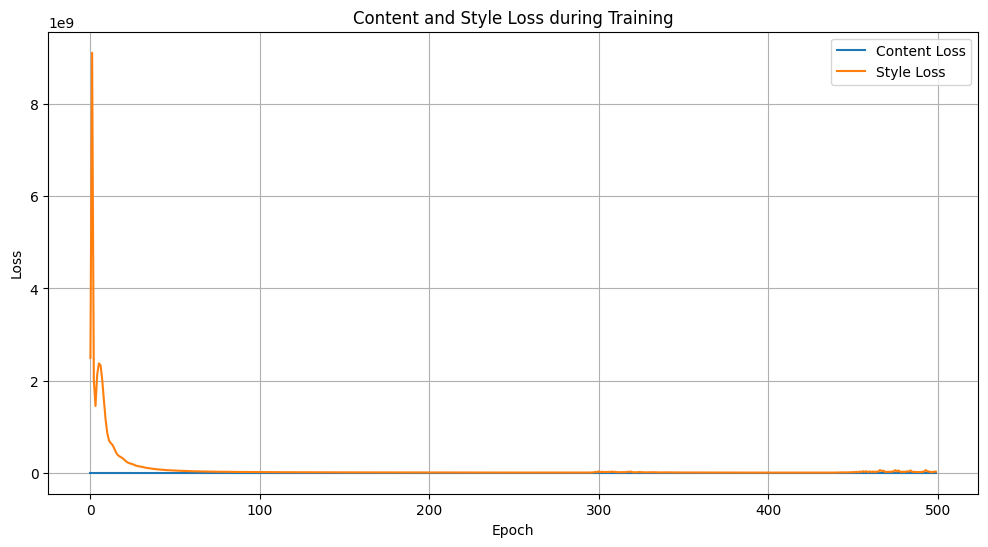

In [46]:
# Plot the content and style losses
plt.figure(figsize=(12, 6))
plt.plot(content_losses_list, label='Content Loss')
plt.plot(style_losses_list, label='Style Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Content and Style Loss during Training')
plt.legend()
plt.grid(True)
plt.show()

Now that you have style transfer working, the results may not look very appealing. Different content and style images require different hyperparameters, so you should play around with different network layers, learning rates, and loss weighting to get the best results.